In [40]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_absolute_error, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('SpotifyFeatures.csv')
df.shape

(232725, 18)

In [3]:
df.sample(5)

genre         artist_name                            track_name  \
152421         R&B       Fifth Harmony  Work from Home (feat. Ty Dolla $ign)   
159631   Reggaeton              Vico C    El Bueno, El Malo Y El Feo - Remix   
178511        Jazz             Annella                          Bass Me Baby   
84623          R&B       Chloe x Halle                              I Say So   
206356  Soundtrack  Benjamin Wallfisch                     Hannah and Volmer   

                      track_id  popularity  acousticness  danceability  \
152421  4tCtwWceOPWzenK2HAIJSb          80       0.10300         0.803   
159631  2P7xMkGaespgqauedWDLZJ          44       0.13400         0.751   
178511  1JRJ5YYPN1di8OAQ4wmsTZ          38       0.00333         0.711   
84623   4fhQ1ZR0VfptVsCNtXccuZ          41       0.17200         0.584   
206356  5XheHbPvouvFpUCNeZhG6b          21       0.96700         0.180   

        duration_ms  energy  instrumentalness key  liveness  loudness   mode  \
152421       214480  0.5850          0.000004  G#    0.0644    -5.861  Major   
159631       269187  0.8970          0.000303  A#    0.0471    -2.521  Minor   
178511       230631  0.8590          0.000000   A    0.1590    -4.575  Minor   
84623        158853  0.6860          0.059700  G#    0.1270    -6.484  Major   
206356       274752  0.0781          0.911000   B    0.1250   -17.815  Minor   

        speechiness    tempo time_signature  valence  
152421       0.0432  105.017            4/4   0.5930  
159631       0.1300   93.934            4/4   0.7680  
178511       0.0639  126.032            4/4   0.7690  
84623        0.0353  135.035            4/4   0.2370  
206356       0.0389  134.495            4/4   0.0355

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   artist_name       232725 non-null  object 
 2   track_name        232725 non-null  object 
 3   track_id          232725 non-null  object 
 4   popularity        232725 non-null  int64  
 5   acousticness      232725 non-null  float64
 6   danceability      232725 non-null  float64
 7   duration_ms       232725 non-null  int64  
 8   energy            232725 non-null  float64
 9   instrumentalness  232725 non-null  float64
 10  key               232725 non-null  object 
 11  liveness          232725 non-null  float64
 12  loudness          232725 non-null  float64
 13  mode              232725 non-null  object 
 14  speechiness       232725 non-null  float64
 15  tempo             232725 non-null  float64
 16  time_signature    23

## Exploratory Data Analysis

### check uniqueness

In [5]:
df.shape[0] == df.track_id.nunique()

False

In [6]:
df.track_id.nunique() == (df.artist_name + df.track_name).nunique()

False

In [7]:
df[df.track_id == '6EFsue2YbIG4Qkq8Zr9Rir']

genre artist_name     track_name                track_id  popularity  \
85642    R&B     R.LUM.R  With My Words  6EFsue2YbIG4Qkq8Zr9Rir          44   
232723  Soul     R.LUM.R  With My Words  6EFsue2YbIG4Qkq8Zr9Rir          44   

        acousticness  danceability  duration_ms  energy  instrumentalness key  \
85642          0.262         0.745       222442   0.704               0.0   A   
232723         0.262         0.745       222442   0.704               0.0   A   

        liveness  loudness   mode  speechiness    tempo time_signature  \
85642      0.333    -7.137  Major        0.146  100.031            4/4   
232723     0.333    -7.137  Major        0.146  100.031            4/4   

        valence  
85642     0.489  
232723    0.489

In [8]:
df[df.track_id == '000xQL6tZNLJzIrtIgxqSl']

genre artist_name      track_name                track_id  popularity  \
14492   Dance        ZAYN  Still Got Time  000xQL6tZNLJzIrtIgxqSl          70   
110840    Pop        ZAYN  Still Got Time  000xQL6tZNLJzIrtIgxqSl          70   

        acousticness  danceability  duration_ms  energy  instrumentalness key  \
14492          0.131         0.748       188491   0.627               0.0   G   
110840         0.131         0.748       188491   0.627               0.0   G   

        liveness  loudness   mode  speechiness    tempo time_signature  \
14492     0.0852    -6.029  Major       0.0644  120.963            4/4   
110840    0.0852    -6.029  Major       0.0644  120.963            4/4   

        valence  
14492     0.524  
110840    0.524

##### some songs are duplicated by track_id because of their multi-genres

### check correlation

Text(0.5, 1.0, 'Correlation Heatmap')

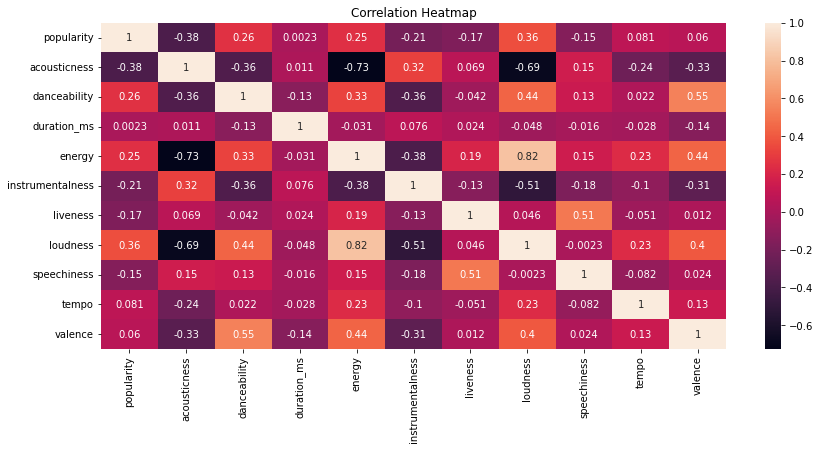

In [9]:
plt.figure(figsize=(14,6))
heatmap = sns.heatmap(df.corr(method = 'pearson'), annot = True)
heatmap.set_title('Correlation Heatmap')

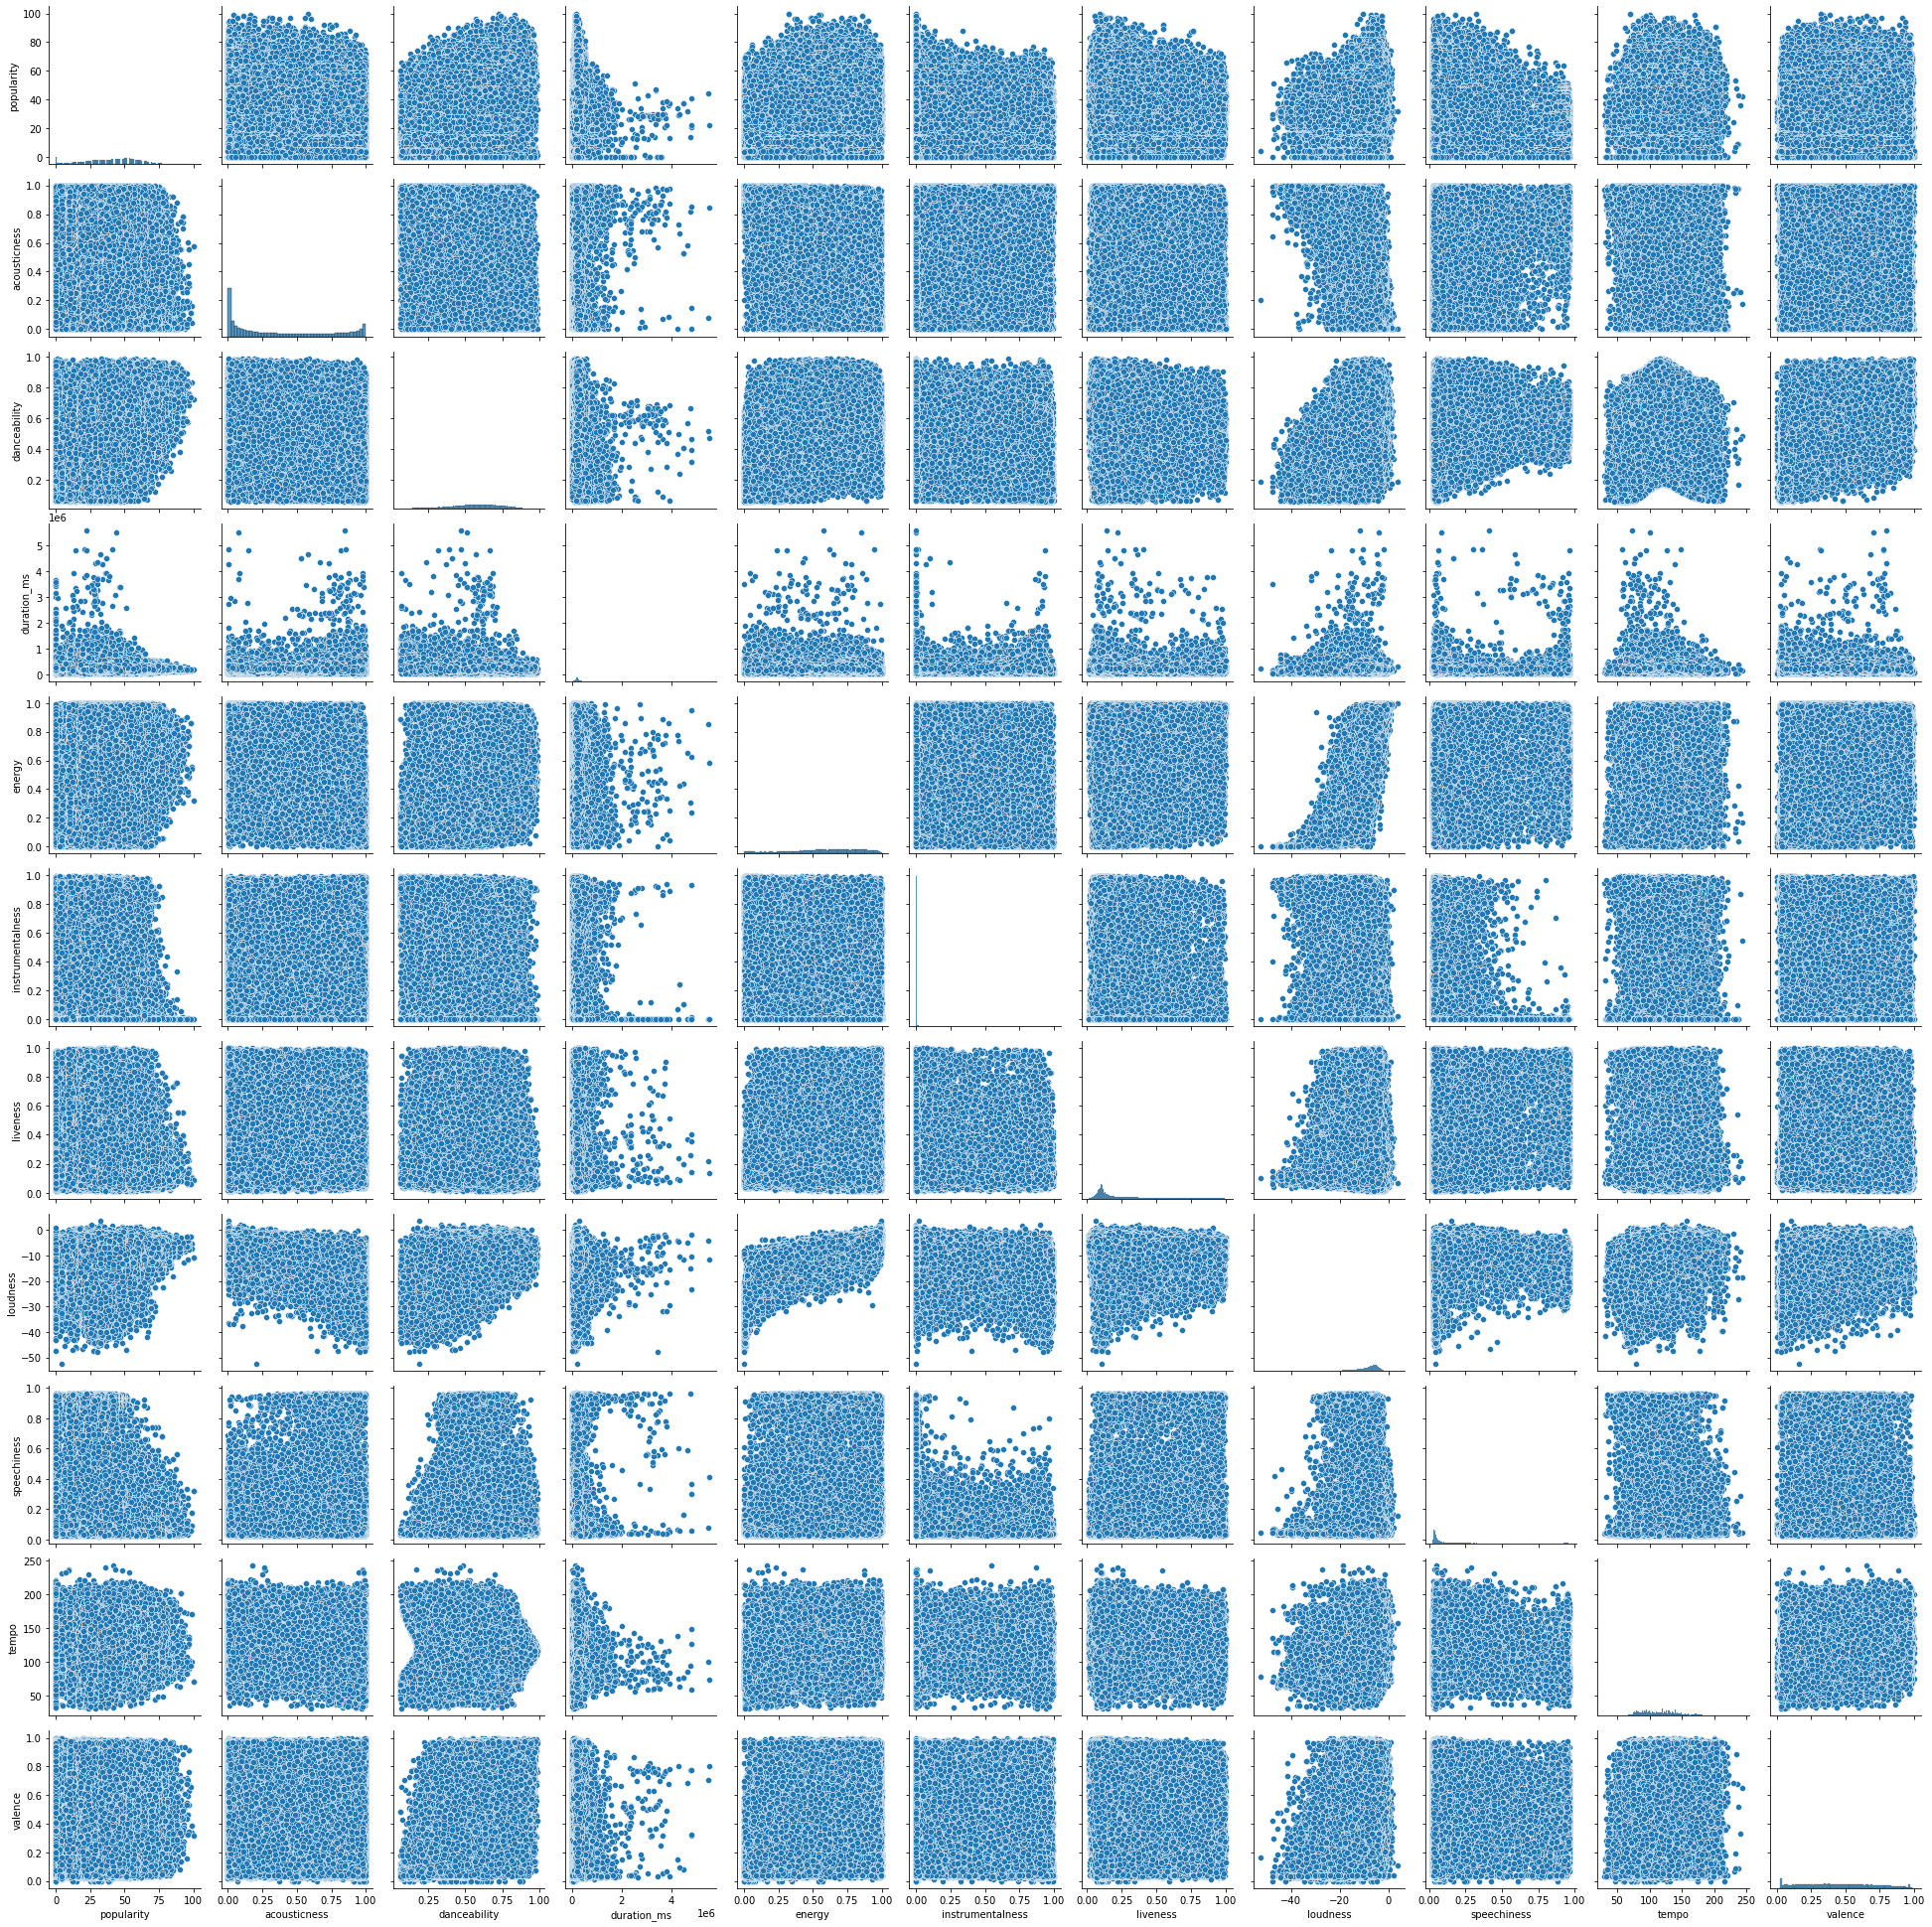

In [10]:
g = sns.PairGrid(df)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

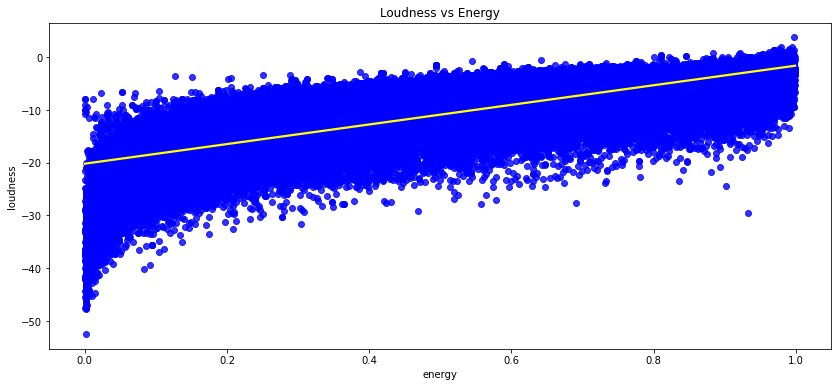

In [11]:
plt.figure(figsize=(14,6))
sns.regplot(data = df , x = 'energy' , y = 'loudness', scatter_kws = {'color':'blue'} , line_kws = {'color':'yellow'}).set(title = 'Loudness vs Energy')
plt.show()

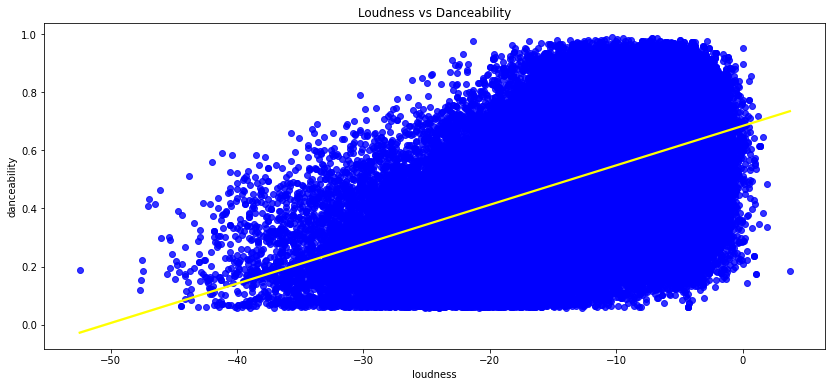

In [12]:
plt.figure(figsize=(14,6))
sns.regplot(data = df , x = 'loudness' , y = 'danceability', scatter_kws = {'color':'blue'} , line_kws = {'color':'yellow'}).set(title = 'Loudness vs Danceability')
plt.show()

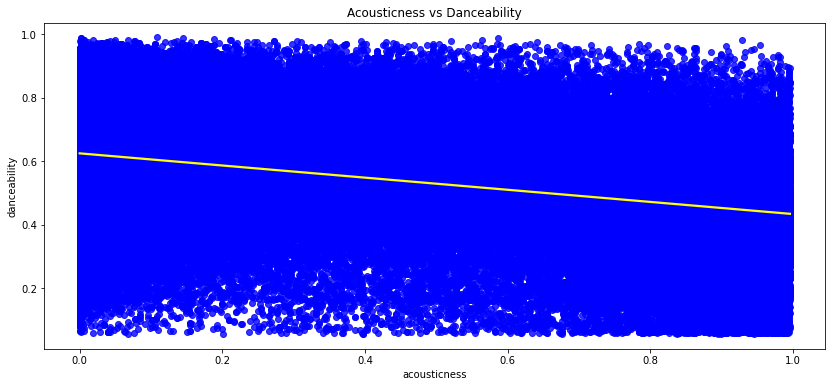

In [13]:
plt.figure(figsize=(14,6))
sns.regplot(data = df , x = 'acousticness' , y = 'danceability', scatter_kws = {'color':'blue'} , line_kws = {'color':'yellow'}).set(title = 'Acousticness vs Danceability')
plt.show()

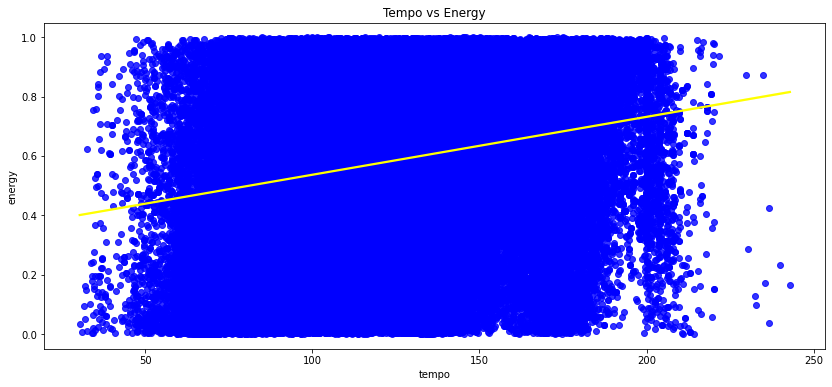

In [14]:
plt.figure(figsize=(14,6))
sns.regplot(data = df , x = 'tempo' , y = 'energy', scatter_kws = {'color':'blue'} , line_kws = {'color':'yellow'}).set(title = 'Tempo vs Energy')
plt.show()

### top n of some columns

<AxesSubplot:>

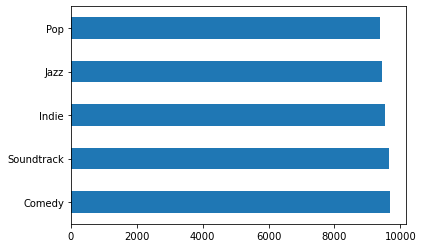

In [15]:
df.genre.value_counts().sort_values(ascending = False).head(5).plot(kind = 'barh')

<AxesSubplot:>

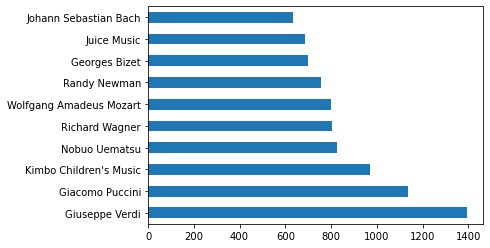

In [16]:
df.artist_name.value_counts().sort_values(ascending = False).head(10).plot(kind = 'barh')

<AxesSubplot:>

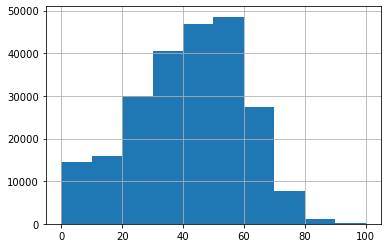

In [17]:
df.popularity.hist()
# need to repeat this for unique data

## Preprocess

In [18]:
model_df = df.set_index('track_id')
model_df.drop(columns = ['artist_name', 'track_name'], inplace = True)
model_df.shape

(232725, 15)

### filling na

In [19]:
model_df.isna().sum()

genre               0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64

### generating dummies // for unique index

In [20]:
temp = pd.get_dummies(model_df[['genre']], columns = ['genre'], drop_first = False)
model_df = pd.get_dummies(model_df.drop(columns = ['genre']).drop_duplicates(), columns = ['key', 'mode', 'time_signature'], drop_first = True)
model_df = model_df.merge(temp.groupby('track_id').sum(), how = 'left', left_index = True, right_index = True)
model_df.shape

(190959, 54)

### ensuring uniqueness
some of the track_ids have multiple popularity values

In [21]:
model_df[model_df.index == '6CN8zBU4Qzm6Wp9nmGpauZ']

popularity  acousticness  danceability  duration_ms  \
track_id                                                                      
6CN8zBU4Qzm6Wp9nmGpauZ          47        0.0117         0.675       260357   
6CN8zBU4Qzm6Wp9nmGpauZ          54        0.0117         0.675       260357   
6CN8zBU4Qzm6Wp9nmGpauZ          55        0.0117         0.675       260357   

                        energy  instrumentalness  liveness  loudness  \
track_id                                                               
6CN8zBU4Qzm6Wp9nmGpauZ     0.6           0.00547    0.0866    -6.261   
6CN8zBU4Qzm6Wp9nmGpauZ     0.6           0.00547    0.0866    -6.261   
6CN8zBU4Qzm6Wp9nmGpauZ     0.6           0.00547    0.0866    -6.261   

                        speechiness    tempo  ...  genre_Pop  genre_R&B  \
track_id                                      ...                         
6CN8zBU4Qzm6Wp9nmGpauZ       0.0345  112.005  ...          0          0   
6CN8zBU4Qzm6Wp9nmGpauZ       0.0345  112.005  ...          0          0   
6CN8zBU4Qzm6Wp9nmGpauZ       0.0345  112.005  ...          0          0   

                        genre_Rap  genre_Reggae  genre_Reggaeton  genre_Rock  \
track_id                                                                       
6CN8zBU4Qzm6Wp9nmGpauZ          0             0                0           1   
6CN8zBU4Qzm6Wp9nmGpauZ          0             0                0           1   
6CN8zBU4Qzm6Wp9nmGpauZ          0             0                0           1   

                        genre_Ska  genre_Soul  genre_Soundtrack  genre_World  
track_id                                                                      
6CN8zBU4Qzm6Wp9nmGpauZ          0           1                 0            0  
6CN8zBU4Qzm6Wp9nmGpauZ          0           1                 0            0  
6CN8zBU4Qzm6Wp9nmGpauZ          0           1                 0            0  

[3 rows x 54 columns]

In [22]:
model_df[model_df.index == '5fdzPMOxUqVJYSzTP5cFP7']

popularity  acousticness  danceability  duration_ms  \
track_id                                                                      
5fdzPMOxUqVJYSzTP5cFP7          57         0.202         0.769       186333   
5fdzPMOxUqVJYSzTP5cFP7          59         0.202         0.769       186333   
5fdzPMOxUqVJYSzTP5cFP7          60         0.202         0.769       186333   

                        energy  instrumentalness  liveness  loudness  \
track_id                                                               
5fdzPMOxUqVJYSzTP5cFP7   0.654          0.000574     0.148    -6.295   
5fdzPMOxUqVJYSzTP5cFP7   0.654          0.000574     0.148    -6.295   
5fdzPMOxUqVJYSzTP5cFP7   0.654          0.000574     0.148    -6.295   

                        speechiness    tempo  ...  genre_Pop  genre_R&B  \
track_id                                      ...                         
5fdzPMOxUqVJYSzTP5cFP7         0.08  102.009  ...          0          1   
5fdzPMOxUqVJYSzTP5cFP7         0.08  102.009  ...          0          1   
5fdzPMOxUqVJYSzTP5cFP7         0.08  102.009  ...          0          1   

                        genre_Rap  genre_Reggae  genre_Reggaeton  genre_Rock  \
track_id                                                                       
5fdzPMOxUqVJYSzTP5cFP7          0             0                0           0   
5fdzPMOxUqVJYSzTP5cFP7          0             0                0           0   
5fdzPMOxUqVJYSzTP5cFP7          0             0                0           0   

                        genre_Ska  genre_Soul  genre_Soundtrack  genre_World  
track_id                                                                      
5fdzPMOxUqVJYSzTP5cFP7          0           1                 0            0  
5fdzPMOxUqVJYSzTP5cFP7          0           1                 0            0  
5fdzPMOxUqVJYSzTP5cFP7          0           1                 0            0  

[3 rows x 54 columns]

In [23]:
model_df = model_df.reset_index().drop_duplicates(subset = ['track_id'], keep = False).set_index('track_id')

In [24]:
model_df.shape[0] == model_df.index.nunique()

True

### labelling 

In [25]:
model_df['pop_bin'] = pd.cut(model_df['popularity'], bins = [-1, 25, 50, 100], labels = ['low', 'mid', 'high'])

### feature elimination
after getting base scores for each model, (return to this step and) picked the best and run RFECV with it

In [26]:
def recursive_feature_selection(self, target, estimator):
    rfe = RFECV(estimator = estimator, min_features_to_select = 5, step = 1)
    x = self.drop(target, axis = 1)
    y = self[target]
    temp_x = rfe.fit(x,y)
    cols = temp_x.get_support(indices = True)
    return list(x.iloc[:, cols].columns)

In [27]:
rfecv_cols = recursive_feature_selection(model_df.drop(columns = ['popularity']), "pop_bin", lgb.LGBMClassifier(random_state = 0))
rfecv_cols.append('pop_bin')
model_df = model_df[rfecv_cols]
model_df.shape

(164060, 43)

In [28]:
rfecv_cols

['acousticness',
 'danceability',
 'duration_ms',
 'energy',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness',
 'tempo',
 'valence',
 'key_E',
 'key_F#',
 'key_G',
 'mode_Minor',
 'time_signature_4/4',
 'genre_A Capella',
 'genre_Alternative',
 'genre_Anime',
 'genre_Blues',
 "genre_Children's Music",
 'genre_Children’s Music',
 'genre_Classical',
 'genre_Comedy',
 'genre_Country',
 'genre_Dance',
 'genre_Electronic',
 'genre_Folk',
 'genre_Hip-Hop',
 'genre_Indie',
 'genre_Jazz',
 'genre_Movie',
 'genre_Opera',
 'genre_Pop',
 'genre_R&B',
 'genre_Rap',
 'genre_Reggae',
 'genre_Reggaeton',
 'genre_Rock',
 'genre_Ska',
 'genre_Soul',
 'genre_Soundtrack',
 'genre_World',
 'pop_bin']

## Modelling

### as a regression problem

<AxesSubplot:>

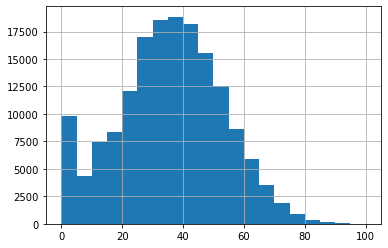

In [58]:
model_df.popularity.hist(bins = 20)

In [233]:
label = model_df.popularity
data = model_df.drop(columns = ["popularity", "pop_bin"])

x_train, x_test, y_train, y_test = train_test_split(data, label, test_size = 0.3, random_state = 42)

In [234]:
log_model = LogisticRegression(random_state = 0)
log_model.fit(x_train, y_train)
y_pred_log = log_model.predict(x_test)
print("Mean Accuracy:", log_model.score(x_test, y_test))
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred_log))

Mean Accuracy: 0.036409443699459546
Mean Absolute Error: 35.13271567312772


### as a classification problem

In [29]:
def scores(y_test, y_pred):
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report\n", classification_report(y_test, y_pred))

In [30]:
model_df.pop_bin.value_counts()

mid     87834
low     45119
high    31107
Name: pop_bin, dtype: int64

In [31]:
label = model_df.pop_bin
data = model_df.drop(columns = ["pop_bin"])

x_train, x_test, y_train, y_test = train_test_split(data, label, test_size = 0.3, random_state = 42, stratify = label)

#### Decision Tree

In [32]:
dt_model = DecisionTreeClassifier(random_state = 0)
dt_model.fit(x_train, y_train)
y_pred_dt = dt_model.predict(x_test)
scores(y_test, y_pred_dt)


Confusion Matrix:
 [[ 6092   260  2980]
 [  283  9295  3958]
 [ 3229  4282 18839]]

Classification Report
               precision    recall  f1-score   support

        high       0.63      0.65      0.64      9332
         low       0.67      0.69      0.68     13536
         mid       0.73      0.71      0.72     26350

    accuracy                           0.70     49218
   macro avg       0.68      0.68      0.68     49218
weighted avg       0.70      0.70      0.70     49218



#### Random Forest

In [33]:
rf_model = RandomForestClassifier(random_state = 0)
rf_model.fit(x_train, y_train)
y_pred_rf = rf_model.predict(x_test)
scores(y_test, y_pred_rf)


Confusion Matrix:
 [[ 6328    63  2941]
 [   34  9951  3551]
 [ 1100  2417 22833]]

Classification Report
               precision    recall  f1-score   support

        high       0.85      0.68      0.75      9332
         low       0.80      0.74      0.77     13536
         mid       0.78      0.87      0.82     26350

    accuracy                           0.79     49218
   macro avg       0.81      0.76      0.78     49218
weighted avg       0.80      0.79      0.79     49218



#### XGBoost

In [34]:
xgb_label_train = y_train.map({'low': 0, 'mid': 1, 'high': 2})
xgb_label_test = y_test.map({'low': 0, 'mid': 1, 'high': 2})

xg_model = XGBClassifier(random_state = 0)
xg_model.fit(x_train, xgb_label_train)
y_pred_xg = xg_model.predict(x_test)
scores(xgb_label_test, y_pred_xg)


Confusion Matrix:
 [[ 9993  3509    34]
 [ 2584 22648  1118]
 [   71  2976  6285]]

Classification Report
               precision    recall  f1-score   support

           0       0.79      0.74      0.76     13536
           1       0.78      0.86      0.82     26350
           2       0.85      0.67      0.75      9332

    accuracy                           0.79     49218
   macro avg       0.80      0.76      0.78     49218
weighted avg       0.79      0.79      0.79     49218



#### LightGBM

In [35]:
lgbm_model = lgb.LGBMClassifier(random_state = 0)
lgbm_model.fit(x_train, y_train)
y_pred_lgbm = lgbm_model.predict(x_test)
scores(y_test, y_pred_lgbm)


Confusion Matrix:
 [[ 6351    67  2914]
 [   32  9920  3584]
 [ 1123  2517 22710]]

Classification Report
               precision    recall  f1-score   support

        high       0.85      0.68      0.75      9332
         low       0.79      0.73      0.76     13536
         mid       0.78      0.86      0.82     26350

    accuracy                           0.79     49218
   macro avg       0.81      0.76      0.78     49218
weighted avg       0.79      0.79      0.79     49218



#### SVM
takes more than 8 hours // couldn't get the model

In [ ]:
svm_model = svm.SVC(random_state = 0)
svm_model.fit(x_train, y_train)
y_pred_svm = svm_model.predict(x_test)
scores(y_test, y_pred_svm)

#### Naive Bayes

In [36]:
gnb_model = GaussianNB()
gnb_model.fit(x_train, y_train)
y_pred_gnb = gnb_model.predict(x_test)
scores(y_test, y_pred_gnb)


Confusion Matrix:
 [[ 2576    96  6660]
 [  956  1273 11307]
 [ 3861  1565 20924]]

Classification Report
               precision    recall  f1-score   support

        high       0.35      0.28      0.31      9332
         low       0.43      0.09      0.15     13536
         mid       0.54      0.79      0.64     26350

    accuracy                           0.50     49218
   macro avg       0.44      0.39      0.37     49218
weighted avg       0.47      0.50      0.44     49218



##### decided to treat the problem as a classification problem

### parameter tuning for the best model

In [47]:
lgb_model_gs = GridSearchCV(lgb.LGBMClassifier(), 
                           {'learning_rate': np.linspace(0.1, 0.9, 3),
                            'tree_learner': ['serial', 'feature', 'data', 'voting'],
                            'max_depth': [None, 5]},
                            cv = 5, scoring = 'f1_weighted', n_jobs = 8, verbose = 2)
lgb_model_gs.fit(x_train, y_train)

print("Tuned hypterparameters:", lgb_model_gs.best_params_)
scores(y_test, lgb_model_gs.predict(x_test))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Tuned hypterparameters: {'learning_rate': 0.1, 'max_depth': None, 'tree_learner': 'serial'}

Confusion Matrix:
 [[ 6351    67  2914]
 [   32  9920  3584]
 [ 1123  2517 22710]]

Classification Report
               precision    recall  f1-score   support

        high       0.85      0.68      0.75      9332
         low       0.79      0.73      0.76     13536
         mid       0.78      0.86      0.82     26350

    accuracy                           0.79     49218
   macro avg       0.81      0.76      0.78     49218
weighted avg       0.79      0.79      0.79     49218



##### according to gridsearch above, the best results are coming from default parameters.